<a href="https://colab.research.google.com/github/januz08/yolov3/blob/main/YOLOv3_Notebook_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de YOLOv3- Darknet

- Como Yolo trabaja con solo un vistazo a la imagen, las ventanas deslizantes no son el enfoque correcto. En cambio, toda la imagen se puede dividir en la cuadrícula. Esta cuadrícula tendrá dimensiones 𝑆 × 𝑆. Ahora, cada celda es responsable de predecir algunas cosas diferentes.

- Lo primero, cada celda es responsable de predecir cierto número de cuadros delimitadores. Además, cada celda predecirá el valor de confianza para cada cuadro delimitador. En otras palabras, esta es una probabilidad de que una caja contenga un objeto. En caso de que no haya ningún objeto en alguna celda de la cuadrícula, es importante que el valor de confianza sea muy bajo para esa celda.

- Cuando visualizamos todas estas predicciones, obtenemos un mapa de todos los objetos y un montón de cuadros que se clasifica según su valor de confianza.

<img src="NotebookIMG/yolo_diagram.jpg">


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

from absl import logging
from itertools import repeat
from random import randint

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definiendo valores




In [ ]:
yolo_iou_threshold   = 0.6 # iou threshold
yolo_score_threshold = 0.6 # score threshold

weightsyolov3 = '/content/drive/MyDrive/YOLOv3/Model/yolov3.weights' # path to weights file
weights= 'Checkpoints/yolov3.tf' # path to checkpoints file
size= 416             #resize images to\
checkpoints = '/content/drive/MyDrive/YOLOv3/Checkpoints/yolov3.tf.index'
num_classes =  80      # number of classes in the model

**Lista de capas en YOLOv3 que son Fully Convolutional Network**

In [ ]:
YOLO_V3_LAYERS = [
  'yolo_darknet',
  'yolo_conv_0',
  'yolo_output_0',
  'yolo_conv_1',
  'yolo_output_1',
  'yolo_conv_2',
  'yolo_output_2',
]

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.12.0


''

In [ ]:
import warnings
warnings.filterwarnings("ignore")

print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False True


### Función que carga los pesos del modelo entrenado en Darknet

In [ ]:
def load_darknet_weights(model, weights_file):
  wf = open(weights_file, 'rb')
  major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
  layers = YOLO_V3_LAYERS

  for layer_name in layers:
    sub_model = model.get_layer(layer_name)
    for i, layer in enumerate(sub_model.layers):
      if not layer.name.startswith('conv2d'):
        continue
      batch_norm = None
      if i + 1 < len(sub_model.layers) and \
            sub_model.layers[i + 1].name.startswith('batch_norm'):
        batch_norm = sub_model.layers[i + 1]

      logging.info("{}/{} {}".format(
        sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

      filters = layer.filters
      size = layer.kernel_size[0]
      in_dim = layer.input_shape[-1]

      if batch_norm is None:
        conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
      else:
        bn_weights = np.fromfile(
          wf, dtype=np.float32, count=4 * filters)

        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

      conv_shape = (filters, in_dim, size, size)
      conv_weights = np.fromfile(
        wf, dtype=np.float32, count=np.product(conv_shape))

      conv_weights = conv_weights.reshape(
        conv_shape).transpose([2, 3, 1, 0])

      if batch_norm is None:
        layer.set_weights([conv_weights, conv_bias])
      else:
        layer.set_weights([conv_weights])
        batch_norm.set_weights(bn_weights)

  assert len(wf.read()) == 0, 'failed to read all data'
  wf.close()

### Función que calcula la interseccíon sobre las uniones

Ahora, si tomamos la probabilidad y la multiplicamos por los valores de confianza, obtenemos todos los cuadros delimitadores ponderados por sus probabilidades de contener ese objeto.

Un umbral simple nos librará de todas las predicciones de bajo valor de confianza. Para el siguiente paso, es importante definir qué es la Intersección sobre Unión (IoU). La intersección sobre la unión calcula el tamaño de la intersección y la divide por el tamaño de la unión.

<img src="NotebookIMG/Yolo-IoU.png">

In [ ]:
def interval_overlap(interval_1, interval_2):
  x1, x2 = interval_1
  x3, x4 = interval_2
  if x3 < x1:
    return 0 if x4 < x1 else (min(x2,x4) - x1)
  else:
    return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
  intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
  intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
  intersect_area = intersect_w * intersect_h
  
  w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
  w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
  
  union_area = w1*h1 + w2*h2 - intersect_area
  return float(intersect_area) / union_area

### Function for drawing bounding box, class name and probability

- Lo segundo, cada celda es responsable de predecir las probabilidades de clase. Esto no quiere decir que alguna celda de la cuadrícula contenga algún objeto, esto es solo una probabilidad. Entonces, si una celda de la grilla predice automóvil, no está diciendo que haya un automóvil, solo está diciendo que si hay un objeto, ese objeto es un automóvil.

-  Describamos con más detalles cómo se ve la salida.

- En Yolo, los **AnchorBox** se usan para predecir cuadros delimitadores. La idea principal de las cajas de anclaje es predefinir dos formas diferentes. Se llaman cajas de anclaje o formas de caja de anclaje. De esta manera, podremos asociar dos predicciones con los dos cuadros de anclaje. En general, podríamos usar incluso más cuadros de anclaje (cinco o incluso más). Las anclas se calcularon en el conjunto de datos COCO usando el agrupamiento de k-means.

<img src="NotebookIMG/yolo-anchor-boxes.png">

Tenemos una cuadrícula y cada celda va a predecir:

     Para cada cuadro delimitador:
         4 coordenadas (𝑡𝑥, 𝑡𝑦, 𝑡𝑤, 𝑡ℎ)
         1 error de objetividad, que es la puntuación de confianza de si hay un objeto o no
     Cierto número de probabilidades de clase

Si hay algún desplazamiento desde la esquina superior izquierda por 𝑐𝑥, 𝑐𝑦, entonces las predicciones corresponden a

La siguiente fórmula describe cómo se transforma la salida de la red para obtener predicciones de cuadro delimitador:

\begin{eqnarray*}
b_x &=& \sigma(t_x) + c_x\\
b_y &=& \sigma(t_y) + c_y\\
b_w &=& p_w e^{t_w}\\
b_h &=& p_h e^{t_h}
\end{eqnarray*}

De donde $p_c, b_x, b_y , b_h, b_w$ son las coordenadas centrales x, y, el ancho y la altura de nuestra predicción. $t_x, t_y, t_w, t_h$ es lo que produce la red. $c_x$ y $x_y$ son las coordenadas superior izquierda de la cuadrícula. $p_w$ y $p_h$ son anclas de dimensiones para la caja.



## Cuenta objetos en una imagent total

In [ ]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
 
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

    #boxColor = (int(255 * (1 - (classes[i] ** 2))), int(255 * (score[i] ** 2)),int(255 * (1 - (classes[i] ** 2))))
    boxColor = (randint(0,255)),int(255 * (1 - (classes[i] ** 2))), int(255 *(score[i] ** 2)) #R G B*
   
    img = cv2.rectangle(img, x1y1, x2y2, boxColor, 3)
    img = cv2.putText(img, '{} {:.1f}'.format(
      class_names[int(classes[i])],i,score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, boxColor, 2)
    print('class: {0}, score: {1:.2f},'.format(class_names[i], score[i]))
    print('box coordinate x,y,w,h: {0}'.format(boxes[i]))

  return img

## Cuenta objetos de cada clase en una imagen.

In [ ]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
 
  class_count = {}  # Diccionario para contar el número de imágenes por clase

  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

    boxColor = (int(255 * (1 - (classes[i] ** 2))), int(255 * (score[i] ** 2)), int(255 * (1 - (classes[i] ** 2))))

    img = cv2.rectangle(img, x1y1, x2y2, boxColor, 2)
    img = cv2.putText(img, '{} {:.1f}'.format(
      class_names[int(classes[i])], i, score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, boxColor, 2)

    class_name = class_names[int(classes[i])]
    if class_name not in class_count:
      class_count[class_name] = 1
    else:
      class_count[class_name] += 1

    print('class: {0}, score: {1:.2f},'.format(class_name, score[i]))
    print('box coordinate x,y,w,h: {0}'.format(boxes[i]))

  print('Class count:', class_count)  # Imprimir el conteo de imágenes por clase

  return img


## Solo detecta y clasifica objetos en una imagen

In [ ]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
 
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

    #boxColor = (int(255 * (1 - (classes[i] ** 2))), int(255 * (score[i] ** 2)),int(255 * (1 - (classes[i] ** 2))))
    boxColor = (randint(0,255)),int(255 * (1 - (classes[i] ** 2))), int(255 *(score[i] ** 2)) #R G B*
   
    img = cv2.rectangle(img, x1y1, x2y2, boxColor, 3)
    img = cv2.putText(img, '{} {:.1f}'.format(
      class_names[int(classes[i])],score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, boxColor, 1)
    print('class: {0}, score: {1:.2f},'.format(class_names[i], score[i]))
    print('box coordinate x,y,w,h: {0}'.format(boxes[i]))

  return img

## Batch Normalization

### ¿Cómo funciona la normalización por lotes?

Para aumentar la estabilidad de una red neuronal, la normalización de lotes normaliza la salida de una capa de activación previa restando la media del lote y dividiendo por la desviación estándar del lote.

Sin embargo, después de este cambio / escala de salidas de activación por algunos parámetros inicializados aleatoriamente, los pesos en la siguiente capa ya no son óptimos. SGD (descenso de gradiente estocástico) deshace esta normalización si es una forma de minimizar la función de pérdida.

En consecuencia, la normalización por lotes agrega dos parámetros entrenables a cada capa, por lo que la salida normalizada se multiplica por un parámetro de "desviación estándar" (gamma) y agrega un parámetro "medio" (beta). En otras palabras, la normalización por lotes permite que SGD realice la desnormalización cambiando solo estos dos pesos para cada activación, en lugar de perder la estabilidad de la red cambiando todos los pesos. 


Aquí, también necesitamos definir la función para calcular la intersección sobre la unión. Estamos utilizando la normalización por lotes para normalizar las salidas para acelerar el aprendizaje. tf.keras.layers.BatchNormalization no funciona muy bien para el aprendizaje de transferencia, por lo que aquí se proporciona otra solución para solucionarlo.

<img src="NotebookIMG/batchN.png">
     

In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
  def call(self, x, training=False):
    if training is None: training = tf.constant(False)
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training)

### Defining 3 anchor boxes for each grid

En cada escala definiremos 3 cuadros de anclaje para cada cuadrícula. En este ejemplo, la máscara es:

     0,1,2, lo que significa que usaremos las primeras tres cajas de anclaje
     3,4,5, lo que significa que usaremos el cuarto, quinto y sexto recuadro
     6,7,8, lo que significa que usaremos los cuadros séptimo, octavo y noveno

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

### Custom Layers

In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
  if strides == 1:
    padding = 'same'
  else:
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
    padding = 'valid'
  x = Conv2D(filters=filters, kernel_size=size,
          strides=strides, padding=padding,
          use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm:
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
  return x

def DarknetResidual(x, filters):
  previous  = x
  x = DarknetConv(x, filters // 2, 1)
  x = DarknetConv(x, filters, 3)
  x = Add()([previous , x])
  return x


def DarknetBlock(x, filters, blocks):
  x = DarknetConv(x, filters, 3, strides=2)
  for _ in repeat(None, blocks):
    x = DarknetResidual(x, filters)       
  return x


def Darknet(name=None):
  x = inputs = Input([None, None, 3])
  x = DarknetConv(x, 32, 3)
  x = DarknetBlock(x, 64, 1)
  x = DarknetBlock(x, 128, 2)
  x = x_36 = DarknetBlock(x, 256, 8)
  x = x_61 = DarknetBlock(x, 512, 8)
  x = DarknetBlock(x, 1024, 4)
  return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [ ]:
def YoloConv(filters, name=None):
  def yolo_conv(x_in):
    if isinstance(x_in, tuple):
      inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
      x, x_skip = inputs

      x = DarknetConv(x, filters, 1)
      x = UpSampling2D(2)(x)
      x = Concatenate()([x, x_skip])
    else:
      x = inputs = Input(x_in.shape[1:])

    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  return yolo_conv

In [ ]:
def YoloOutput(filters, anchors, classes, name=None):
  def yolo_output(x_in):
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  return yolo_output

In [ ]:
def yolo_boxes(pred, anchors, classes):
  grid_size = tf.shape(pred)[1]
  box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

  box_xy = tf.sigmoid(box_xy)
  score = tf.sigmoid(score)
  class_probs = tf.sigmoid(class_probs)
  pred_box = tf.concat((box_xy, box_wh), axis=-1)

  grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
  box_wh = tf.exp(box_wh) * anchors

  box_x1y1 = box_xy - box_wh / 2
  box_x2y2 = box_xy + box_wh / 2
  bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

  return bbox, score, class_probs, pred_box

### Non-maximum suppression

- Después de esto, los duplicados aún pueden estar presentes y para deshacernos de ellos, aplicamos la supresión no máxima. 

- La supresión no máxima tomará un cuadro delimitador con la mayor probabilidad y luego mire otro cuadro delimitador que esté cerca del primero y se suprimirán los que tengan la superposición más alta con este (mayor IoU).

Como todo se hace en una sola pasada, es casi tan rápido como la clasificación. Además, todas las detecciones se predicen simultáneamente, lo que significa que el modelo incorpora implícitamente el contexto global. En palabras más simples, puede aprender qué objetos tienden a ocurrir juntos, el tamaño relativo y la ubicación de los objetos, etc.

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
  boxes, conf, out_type = [], [], []

  for output in outputs:
    boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
    conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
    out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

  bbox = tf.concat(boxes, axis=1)
  confidence = tf.concat(conf, axis=1)
  class_probs = tf.concat(out_type, axis=1)

  scores = confidence * class_probs
  
  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
    scores=tf.reshape(
        scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
    max_output_size_per_class=100,
    max_total_size=100,
    iou_threshold=yolo_iou_threshold,
    score_threshold=yolo_score_threshold
  )
  
  return boxes, scores, classes, valid_detections

### Arquitectura de YOLO 

<img src="NotebookIMG/yolo-arch.jpg">

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
          masks=yolo_anchor_masks, classes=80, training=False):
  x = inputs = Input([size, size, channels])

  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

  x = YoloConv(512, name='yolo_conv_0')(x)
  output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  x = YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

  x = YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  if training:
    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

  outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolov3')

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

Function transform targets outputs tuple of shape

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

  N = tf.shape(y_true)[0]

  y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

  anchor_idxs = tf.cast(anchor_idxs, tf.int32)

  indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
  updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
  idx = 0
  for i in tf.range(N):
    for j in tf.range(tf.shape(y_true)[1]):
      if tf.equal(y_true[i][j][2], 0):
        continue
      anchor_eq = tf.equal(
        anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

      if tf.reduce_any(anchor_eq):
        box = y_true[i][j][0:4]
        box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

        anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
        grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

        indexes = indexes.write(
            idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
        updates = updates.write(
          idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
        idx += 1

  return tf.tensor_scatter_nd_update(
    y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
  outputs = []
  grid_size = 13

  anchors = tf.cast(anchors, tf.float32)
  anchor_area = anchors[..., 0] * anchors[..., 1]
  box_wh = y_train[..., 2:4] - y_train[..., 0:2]
  box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
  box_area = box_wh[..., 0] * box_wh[..., 1]
  intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
  iou = intersection / (box_area + anchor_area - intersection)
  anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
  anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

  y_train = tf.concat([y_train, anchor_idx], axis=-1)

  for anchor_idxs in anchor_masks:
    outputs.append(transform_targets_for_output(
      y_train, grid_size, anchor_idxs, classes))
    grid_size *= 2

  return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
  return (tf.image.resize(x_train, (size, size))) / 255

Now we can create our model, load weights and class names. There is 80 of them in Coco dataset. Straight away we can go and test our model with some image.

In [ ]:
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightsyolov3)

yolo.save_weights(checkpoints)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
  "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
  "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
  "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
  "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

## Prediction

In [ ]:
#name = 'street.jpg'
#name = 'city.jpg'
name = 'city3.jpg'
#name = 'street.jpg'
test_path = '/content/drive/MyDrive/YOLOv3/test_images/'
path = test_path+name

image = cv2.imread(path)
cv2.imwrite(name, image)

True

In [ ]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(image, 0)
img = preprocess_image(img, size)

In [ ]:
boxes, scores, classes, nums = yolo(img) #eager mode

In [ ]:
img = draw_outputs(image, (boxes, scores, classes, nums), class_names)
output_detection = cv2.imwrite(test_path+'detected_output_'+name, img)
predict = cv2.imread(test_path+'detected_output_'+name)

class: person, score: 0.98,
box coordinate x,y,w,h: [0.12691617 0.51478326 0.26966932 0.99181736]
class: bicycle, score: 0.97,
box coordinate x,y,w,h: [0.7708491  0.6128386  0.93608356 0.9761183 ]
class: car, score: 0.91,
box coordinate x,y,w,h: [0.39363587 0.6184436  0.50573564 0.8789724 ]
class: motorbike, score: 0.90,
box coordinate x,y,w,h: [0.42403725 0.4473853  0.5298265  0.8126663 ]
class: aeroplane, score: 0.76,
box coordinate x,y,w,h: [0.7041297 0.7802454 0.933054  1.       ]
class: bus, score: 0.76,
box coordinate x,y,w,h: [0.01088186 0.66131836 0.10657871 0.842581  ]
class: train, score: 0.74,
box coordinate x,y,w,h: [0.5454208  0.43632472 0.6665465  0.689216  ]
class: truck, score: 0.70,
box coordinate x,y,w,h: [0.22429222 0.49032477 0.2557669  0.56864613]
class: boat, score: 0.65,
box coordinate x,y,w,h: [0.7172053  0.5903209  0.78184795 0.74070495]
class: traffic light, score: 0.62,
box coordinate x,y,w,h: [0.50626385 0.62397206 0.61645925 0.89072657]
class: fire hydrant,

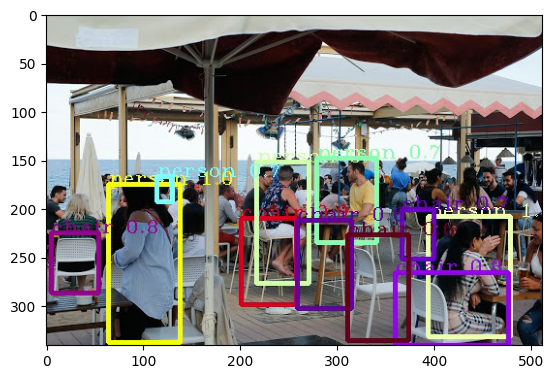

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

image=io.imread(test_path+'detected_output_'+name)/255.0 
plt.imshow(image)

# References

@article{YOLOv3,  
  title={YOLOv3: An Incremental Improvement},  
  author={J Redmon, A Farhadi },
  year={2018}